In [1]:
import numpy as np
import scipy as sp
from scipy import optimize,special,integrate
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import copy

from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
N = 2000
K_big = 101
K = 20

np.random.seed(0)
v = np.random.randn(N)
v /= np.linalg.norm(v)

A_full = GOE_tridiag_model(N,N)
Λ = sp.linalg.eigvalsh_tridiagonal(A_full.diagonal(),A_full.diagonal(1))
A = sp.sparse.spdiags(Λ,0,N,N)

Q,(αs,βs) = lanczos_reorth(A.astype(np.single),v,K_big,0)
Q,(αs_ro,βs_ro) = lanczos_reorth(A.astype(np.longdouble),v.astype(np.longdouble),K_big,K_big)

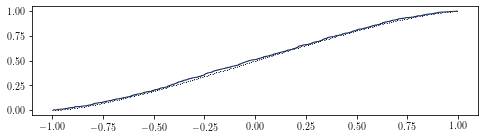

In [4]:
fig,ax = plt.subplots(1,1,figsize=(8,2))

xx = np.linspace(-1,1,500)
ax.step(xx,.5+xx*np.sqrt(1-xx**2)/np.pi + np.arcsin(xx)/np.pi,where='post',lw=1,ls=':',color='k')

ax.step(Λ,np.cumsum(v**2),where='post',lw=lw,color=c1,label='VESD')

plt.savefig('imgs/motivating_VESD.pdf')

In [5]:
np.max(np.abs(αs)),np.max(np.abs(βs[:K_big-1]-.5))

(0.03999854, 0.03254956)

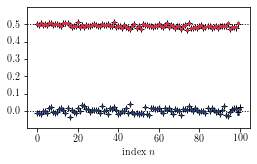

In [6]:
fig,ax = plt.subplots(1,1,figsize=(4,2.4))
plt.subplots_adjust(bottom=0.18)

ax.axhline(0.5,lw=1,ls=':',color='k')
ax.axhline(0,lw=1,ls=':',color='k')

ax.plot(αs_ro,ls='None',marker='+',ms=6,color='k',label=r'$\alpha_i$')
ax.plot(αs,ls='None',marker='o',ms=2,color=c1,label=r'$\overline{\alpha}_i$')

ax.plot(βs_ro[:K_big-1],ls='None',marker='+',ms=6,color='k',label=r'$\beta_i$')
ax.plot(βs[:K_big-1],ls='None',marker='s',ms=2,color=c3,label=r'$\overline{\beta}_i$')



ax.set_ylim(-.1,.6)
ax.set_yticks([0,.1,.2,.3,.4,.5])
#ax.set_yticklabels([0,'.1','','','',.5])
ax.set_xlabel('index $n$')

plt.savefig('imgs/motivating_coeff.pdf')

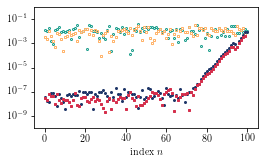

In [7]:
fig,ax = plt.subplots(1,1,figsize=(4,2.4))
plt.subplots_adjust(bottom=0.18)

ax.plot(np.abs(αs),ls='None',marker='o',fillstyle='none',ms=2,color=c2,label=r'$|\alpha_i - \overline{\alpha}_i|$')
ax.plot(np.abs(βs-1/2)[:K_big-1],ls='None',marker='s',fillstyle='none',ms=2,color=c5,label=r'$|\beta_i - \overline{\beta}_i|$')

ax.plot(np.abs(αs-αs_ro),ls='None',marker='o',ms=2,color=c1,label=r'$|\alpha_i - \overline{\alpha}_i|$')
ax.plot(np.abs(βs-βs_ro)[:K_big-1],ls='None',marker='s',ms=2,color=c3,label=r'$|\beta_i - \overline{\beta}_i|$')

ax.set_yscale('log')
ax.set_ylim([1e-10,1e0])
ax.set_yticks([1e-9,1e-7,1e-5,1e-3,1e-1])
ax.set_xlabel('index $n$')

plt.savefig('imgs/motivating_coeff_fe.pdf')

In [8]:
Q_full,(αs_full,βs_full) = lanczos_reorth(A.astype(np.longdouble),v,2*K,2*K)

Nx = 2000
X = np.linspace(-1,1,Nx)
tx = np.zeros((Nx,2*K),dtype=np.longdouble)
tx[:,0] = np.ones(Nx)
tx[:,1] = (X*tx[:,0]-αs_full[0]*tx[:,0])
tx[:,1] /= βs_full[0]


t = np.zeros((N,2*K),dtype=np.longdouble)
t[:,0] = np.ones(N)
t[:,1] = (A@t[:,0]-αs_full[0]*t[:,0])
t[:,1] /= βs_full[0]

T = np.diag(αs[:K]) + np.diag(βs[:K-1],-1) + np.diag(βs[:K-1],1)
e0 = np.zeros(K)
e0[0] = 1

t_fp = np.zeros((K,2*K),dtype=np.longdouble)
t_fp[:,0] = e0
t_fp[:,1] = (T@t_fp[:,0]-αs_full[0]*t_fp[:,0])
t_fp[:,1] /= βs_full[0]

T_ro = np.diag(αs_ro[:K]) + np.diag(βs_ro[:K-1],-1) + np.diag(βs_ro[:K-1],1)
e0 = np.zeros(K)
e0[0] = 1

t_ro = np.zeros((K,2*K),dtype=np.longdouble)
t_ro[:,0] = e0
t_ro[:,1] = (T_ro@t_ro[:,0]-αs_full[0]*t_ro[:,0])
t_ro[:,1] /= βs_full[0]

for i in range(2,2*K):
    tx[:,i] = (X*tx[:,i-1]-αs_full[i-1]*tx[:,i-1])-βs_full[i-2]*tx[:,i-2]
    tx[:,i] /= βs_full[i-1]
    
    t[:,i] = (A@t[:,i-1]-αs_full[i-1]*t[:,i-1])-βs_full[i-2]*t[:,i-2]
    t[:,i] /= βs_full[i-1]
    
    t_fp[:,i] = (T@t_fp[:,i-1]-αs_full[i-1]*t_fp[:,i-1])-βs_full[i-2]*t_fp[:,i-2]
    t_fp[:,i] /= βs_full[i-1]
    
    t_ro[:,i] = (T_ro@t_ro[:,i-1]-αs_full[i-1]*t_ro[:,i-1])-βs_full[i-2]*t_ro[:,i-2]
    t_ro[:,i] /= βs_full[i-1]

In [9]:
np.max(tx)

274.3302510452013775

In [10]:
m_fp = e0.T@t_fp
m_ro = e0.T@t_ro

#m_fp[K:] = 0
#m_ro[K:] = 0

v_new = v*(1+t@(m_fp-m_ro))**.5

In [11]:
np.linalg.norm(v-v_new)

7.3060051622050701715e-07

In [12]:
t_new = np.zeros((N,2*K),dtype=np.longdouble)
t_new[:,0] = v_new
t_new[:,1] = (A@t_new[:,0]-αs_full[0]*t_new[:,0])
t_new[:,1] /= βs_full[0]

for i in range(2,2*K):
    t_new[:,i] = (A@t_new[:,i-1]-αs_full[i-1]*t_new[:,i-1])-βs_full[i-2]*t_new[:,i-2]
    t_new[:,i] /= βs_full[i-1]


In [13]:
m_new = np.ones(N).T@t_new

In [14]:
Q,(αs_new,βs_new) = lanczos_reorth(A.astype(np.longdouble),v_new.astype(np.longdouble),K,K)

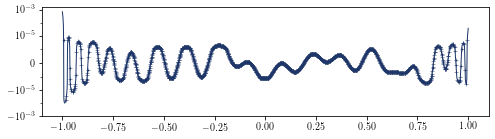

In [15]:
fig,ax = plt.subplots(1,1,figsize=(8,2))

ax.plot(X,tx@(m_fp-m_ro),lw=lw,color=c1,label='$h(\lambda)$')
ax.plot(Λ,t@(m_fp-m_ro),ls='None',marker='+',ms=4,markeredgewidth=.5,color=c1)

ax.set_yscale('symlog',linthreshy=1e-6)

ax.set_yticks([-1e-3,-1e-5,0,1e-5,1e-3])


plt.savefig('imgs/GOE_backwards_h.pdf')

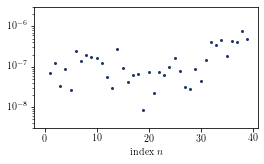

In [16]:
fig,ax = plt.subplots(1,1,figsize=(4,2.4))
plt.subplots_adjust(bottom=0.18)

ax.plot(np.abs(m_ro-m_fp),ls='None',marker='o',ms=2,color=c1,label=r'$|m(i)-\overline{m}(i)|$')

ax.set_xlabel('index $n$')
ax.set_yscale('log')
ax.set_ylim([3e-9,3e-6])
ax.set_yticks([1e-8,1e-7,1e-6])

plt.savefig('imgs/GOE_backwards_moments.pdf')

In [17]:
αs[:K]-αs_new

array([-3.26107685e-19, -2.55803950e-19,  1.08420217e-19,  3.12131641e-19,
       -3.79470760e-19, -9.65617560e-20,  3.11708125e-19, -1.84653183e-19,
        5.14996032e-19, -8.36868552e-19,  6.35274710e-19, -4.23516474e-20,
       -1.30443074e-19,  4.91279109e-20, -2.33781093e-19, -4.23516474e-20,
        3.93023288e-19, -6.70850094e-19,  4.45539330e-19, -2.53262851e-19],
      dtype=float128)

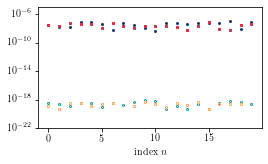

In [18]:
fig,ax = plt.subplots(1,1,figsize=(4,2.4))
plt.subplots_adjust(bottom=0.18)

ax.plot(np.abs(αs-αs_ro)[:K],ls='None',marker='o',ms=2,color=c1,label=r'$|\alpha_i - \overline{\alpha}_i|$')
ax.plot(np.abs(βs-βs_ro)[:K],ls='None',marker='s',ms=2,color=c3,label=r'$|\beta_i - \overline{\beta}_i|$')


ax.plot(np.abs(αs[:K]-αs_new),ls='None',marker='o',fillstyle='none',ms=2,color=c2,label=r'$|\alpha^*_i - \overline{\alpha}_i|$')
ax.plot(np.abs(βs[:K-1]-βs_new[:K-1]),ls='None',marker='s',fillstyle='none',ms=2,color=c5,label=r'$|\beta^*_i - \overline{\beta}_i|$')



ax.set_xlabel('index $n$')
ax.set_yscale('log')
ax.set_ylim([1e-22,1e-5])
ax.set_yticks([1e-22,1e-18,1e-14,1e-10,1e-6])


plt.savefig('imgs/GOE_backwards_coeff_fe.pdf')